In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
%cd /content/drive/MyDrive/Colab Notebooks/딥러닝

/content/drive/MyDrive/Colab Notebooks/딥러닝


### 학습목표
- 베스트 모델 저장하기 / 불러오기
- 학습 중단 기능
- 과적합 방지 - Dropout


### 베스트 모델 저장하기 / 학습 중단

- 손글씨 이미지 데이터셋
  - 훈련 데이터 6만 개. 테스트 데이터 1만 개
  - 0~9까지 숫자 이미지에 대한 라벨링

In [15]:
from tensorflow.keras.datasets import mnist

(X_train, y_train),(X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

- 데이터 확인

3


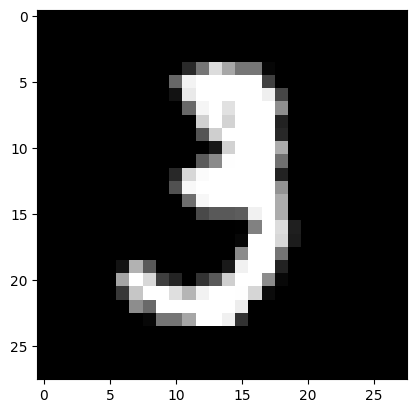

In [16]:
import matplotlib.pyplot as plt

print(y_train[10])
plt.imshow(X_train[10], cmap='gray')
plt.show()

- 이미지 (2차원) -> Dense (1차원) 변환

In [17]:
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

- 스케일링 : 0-255 -> 0.0-1.0

In [18]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [19]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

- 라벨 데이터는 원핫인코딩 (다진분류)

In [20]:
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

y_train_oh.shape, y_test_oh.shape

((60000, 10), (10000, 10))

- 신경망 설계

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model1 = Sequential()
# input_dim : 입력 데이터의 크기(X_train의 크기)
model1.add(Dense(512, activation='relu', input_dim=28*28))
# 10 : 라벨 데이터의 크기(y_train의 크기)
model1.add(Dense(10, activation = 'softmax'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# validation_data : 테스트 데이터가 있는 경우
# validation_split : 테스트 데이터가 있는 경우 훈련 데이터에서 비율만큼 가져온다.
h1 = model1.fit(X_train, y_train_oh, epochs = 20, batch_size = 128,
                validation_data=(X_test, y_test_oh))

Epoch 1/20
469/469 [==============================] - 7s 13ms/step - loss: 0.2695 - accuracy: 0.9242 - val_loss: 0.1348 - val_accuracy: 0.9601
Epoch 2/20
469/469 [==============================] - 7s 14ms/step - loss: 0.1090 - accuracy: 0.9679 - val_loss: 0.0896 - val_accuracy: 0.9729
Epoch 3/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0695 - accuracy: 0.9796 - val_loss: 0.0746 - val_accuracy: 0.9754
Epoch 4/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0492 - accuracy: 0.9856 - val_loss: 0.0761 - val_accuracy: 0.9770
Epoch 5/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0372 - accuracy: 0.9889 - val_loss: 0.0649 - val_accuracy: 0.9811
Epoch 6/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0274 - accuracy: 0.9922 - val_loss: 0.0689 - val_accuracy: 0.9791
Epoch 7/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0203 - accuracy: 0.9941 - val_loss: 0.0703 - val_accuracy: 0.9767

- 시각화

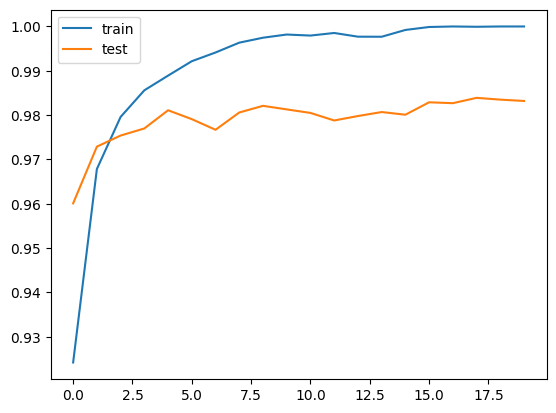

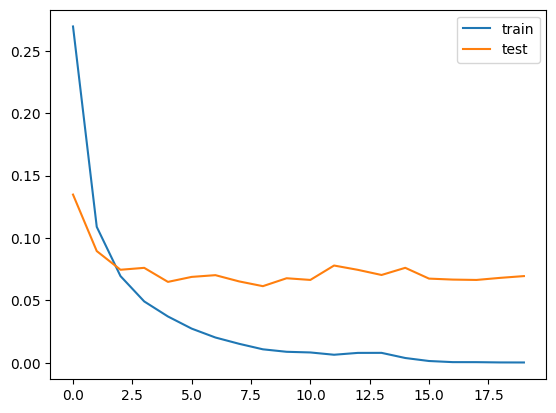

In [29]:
import matplotlib.pyplot as plt

plt.plot(h1.history['accuracy'], label = "train")
plt.plot(h1.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

plt.plot(h1.history['loss'], label = "train")
plt.plot(h1.history['val_loss'], label = "test")
plt.legend()
plt.show()

- 베스트 모델 저장, 학습 중단 설정
  - 베스트 모델 : 학습 중에서 설정한 기준값이 가장 좋은 모델을 저장 (ModelCheckpoint())
  - 학습 모델 : 학습 중에 설정한 기준값이 만족하는 경우에 학습을 중지시키는 기능 (EarlyStopping())

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os

# 모델을 저장할 폴더
model_dir = './model/'

# 만약에 해당 폴더가 없다면 폴더를 생성
if not os.path.exists(model_dir):
  os.mkdir(model_dir)

In [35]:
# {epoch:02d} : epoch 변수의 값을 2자리 정수로 출력
# {loss:.4f} : loss 변수의 값을 소수점 넷째 자리까지로 설정
# {val_loss:.4f} : val_loss 변수의 값을 소수점 넷째 자리까지로 설정
# 파일명 예시 : ./model/model1_20_0.894_0.876.hdf5
file_name = model_dir + "model1_{epoch:02d}_{loss:.4f}_{val_loss:.4f}.hdf5"

# 베스트 모델 저장 설정
# monitor : 베스트 모델을 결정하는 기준값
# save_best_only=True : monitor에서 설정한 기준값이 더 나아지는 경우에만 저장
mc = ModelCheckpoint(file_name, monitor='val_loss', save_best_only=True)

# 학습 중단 기능 : 얼마만큼 학습횟수를 설정할지 알 수 없기 때문에 학습이 더 나아지지 않는 경우에 자동 중지
# monitor : 학습 중단을 결정하는 기준값(가능하면 ModelCheckpoint와 동일한 값을 권장)
# patience : 학습이 더 나아지지 않더라도 기다려주는 횟수
es = EarlyStopping(monitor='val_loss', patience=5)

In [36]:
# callbacks : 반복할 때마다 호출되어 실행
h1 = model1.fit(X_train, y_train_oh, epochs = 40, batch_size = 128,
                validation_data=(X_test, y_test_oh),callbacks=[mc, es])

Epoch 1/40
469/469 [==============================] - 6s 12ms/step - loss: 2.2816e-04 - accuracy: 1.0000 - val_loss: 0.0712 - val_accuracy: 0.9833
Epoch 2/40
  7/469 [..............................] - ETA: 4s - loss: 2.7770e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 7s 14ms/step - loss: 2.1186e-04 - accuracy: 1.0000 - val_loss: 0.0710 - val_accuracy: 0.9837
Epoch 3/40
469/469 [==============================] - 6s 12ms/step - loss: 0.0257 - accuracy: 0.9917 - val_loss: 0.0825 - val_accuracy: 0.9803
Epoch 4/40
469/469 [==============================] - 6s 12ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0773 - val_accuracy: 0.9822
Epoch 5/40
469/469 [==============================] - 8s 17ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0729 - val_accuracy: 0.9837
Epoch 6/40
469/469 [==============================] - 5s 11ms/step - loss: 3.5227e-04 - accuracy: 1.0000 - val_loss: 0.0731 - val_accuracy: 0.9834
Epoch 7/40
469/469 [==============================] - 7s 15ms/step - loss: 2.3057e-04 - accuracy: 1.0000 - val_loss: 0.0733 - val_accuracy: 0.9834


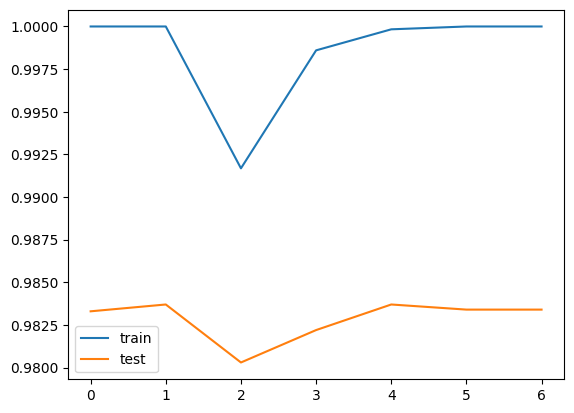

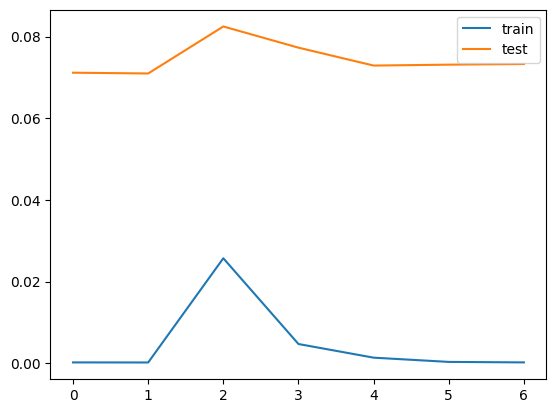

In [37]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(h1.history['accuracy'], label = "train")
plt.plot(h1.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

plt.plot(h1.history['loss'], label = "train")
plt.plot(h1.history['val_loss'], label = "test")
plt.legend()
plt.show()

- 모델 불러오기

In [38]:
from keras.models import load_model

file_name = './model/model1_02_0.0002_0.0710.hdf5'
model2 = load_model(file_name)

model2.evaluate(X_train, y_train_oh)
model2.evaluate(X_test, y_test_oh)

313/313 [==============================] - 1s 3ms/step - loss: 0.0710 - accuracy: 0.9837


[0.07097351551055908, 0.9836999773979187]